# Generates images for processing by the VLM
Prereq for running this script: you need the datasets for the respective generators
  
Download and unzip google's emoji dataset here:
* https://github.com/googlefonts/noto-emoji/
 
Download and unzip twitter's emoji dataset here:
* https://github.com/jdecked/twemoji/

### Dependencies

In [ ]:
import emoji
import os
import cv2
import grapheme
import numpy as np
import shutil

np.random.seed(0)

In [ ]:
OUTPUT_SIZE = 224 # it's a square image
MAX_EMOJIS_PER_ROW = 3
MAX_EMOJI_SEQUENCE_LENGTH = MAX_EMOJIS_PER_ROW * MAX_EMOJIS_PER_ROW


### Utility Functions

In [ ]:
def emoji_str_from_description(desc_str):
    desc_str = desc_str[8:-1]
    desc_list = desc_str.split(' [EM] ')
    return ''.join([emoji.emojize(f":{desc}:") for desc in desc_list])

def get_png_image_from_local_repo(emoji, image_dir, filename_getter_fn, extension="png"):
  filename = filename_getter_fn(emoji, extension)
  path = f'{image_dir}/{filename}'
  if not os.path.exists(path):
    print(f"Couldn't find image for {emoji} at {path}")
    return None
  img = cv2.imread(path, cv2.IMREAD_COLOR)  # Use only RGB channels
  img_new_size = OUTPUT_SIZE // MAX_EMOJIS_PER_ROW
  img = cv2.resize(img, (img_new_size, img_new_size))
  return img

def emoji_to_noto_filename(emoji, extension="png"):
    # Step 1: Get the Unicode code points of the emoji.
    codepoints = [f"U{ord(char):04X}" for char in emoji]
    # Step 2: Join the code points with underscores for ZWJ (Zero-Width Joiner) support.
    # Replace the "U" prefix with a lowercase "u" and remove the "+" symbol.
    file_name_parts = [f"u{codepoints[0][1:].lower()}"]  # First code point with "u"
    for codepoint in codepoints[1:]:
        str = codepoint[1:].lower()
        if str == 'fe0f': # Remove the variation selector
          continue
        file_name_parts.append(codepoint[1:].lower())  # Following code points without "u"
    
    # Step 3: Construct the filename (e.g., emoji_u1f9cf_200d_2640.png)
    file_name = "_".join(file_name_parts)
    return f"emoji_{file_name}.{extension}"

count    394.000000
mean       2.715736
std        1.058303
min        1.000000
25%        2.000000
50%        2.000000
75%        3.000000
max        7.000000
Name: length, dtype: float64

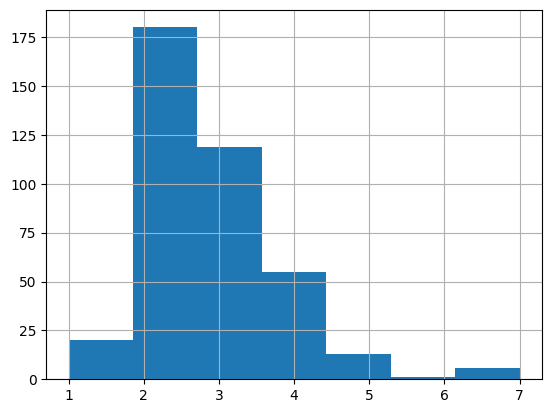

In [8]:
# # count the lengths and graph it
# elco_df['length'] = elco_df['EM'].apply(lambda x: len(list(grapheme.graphemes(x))))
# elco_df['length'].hist(bins=elco_df['length'].max())
# elco_df['length'].describe()

### Main method to generate image datasets

In [ ]:
def generate_dataset(csv_file_path, local_image_dir, output_folder, filename_generator_fn, randomise=False):
  df = pd.read_csv(csv_file_path)
  df['EM'] = df['sent1'].apply(emoji_str_from_description)

  if os.path.exists(output_folder):
    # delete the directory
    shutil.rmtree(output_folder)

  os.makedirs(output_folder)

  undone = 0

  i = -1
  for text in df['EM']:
    i += 1
    units = list(grapheme.graphemes(text))
    units = [unit for unit in units if unit != ',' and unit != ' '] # don't ask me why they're there
    if len(units) > MAX_EMOJI_SEQUENCE_LENGTH:
      print(f"Skipping {text} because it's too long")
      undone += 1
      continue
    
    output_filename = f'{output_folder}/{i}.png'
    
    x = 0
    y = 0
    # Make a white image of size OUTPUT_SIZE x OUTPUT_SIZE
    canvas = np.zeros((OUTPUT_SIZE, OUTPUT_SIZE, 3), dtype=np.uint8)  # RGB image
    
    img_new_size = OUTPUT_SIZE // MAX_EMOJIS_PER_ROW

    if randomise:
      while len(units) < MAX_EMOJI_SEQUENCE_LENGTH:
        units.append(' ')
      np.random.shuffle(units)

    generated = True
    # Generate the image
    for j in range(len(units)):
      unit = units[j]
      if unit == ' ':
        continue
      img = get_png_image_from_local_repo(unit, local_image_dir, filename_generator_fn)
      if img is None:
        undone += 1
        generated = False
        break

      # Ensure img is in RGB before placing it on the canvas
      if img.shape[2] == 4:  # If the image is RGBA, convert it to RGB
          img = img[..., :3]

      # Write the img to canvas starting at x, y
      x_pos = j % MAX_EMOJIS_PER_ROW
      y_pos = j // MAX_EMOJIS_PER_ROW
      x = x_pos * img_new_size
      y = y_pos * img_new_size
      canvas[y:y+img.shape[0], x:x+img.shape[1]] = img
    
    if generated:
      cv2.imwrite(output_filename, canvas)
  
  print(f"Undone: {undone}")

### Calling the main method for each split (val, test, train)

In [ ]:
output_folder = 'generated_img_dataset/google_dataset'
local_image_dir = 'googlefonts-noto-emoji-main-png-512'


datasets = {
  'val': './original_ELCo_dataset/val.csv',
  'test': './original_ELCo_dataset/test.csv',
  'train': './original_ELCo_dataset/train.csv'
}

for dataset_name, csv_file_path in datasets.items():
  output_folder = f'generated_img_dataset/{dataset_name}_google'
  generate_dataset(csv_file_path, local_image_dir, output_folder, emoji_to_noto_filename, randomise=False)

Couldn't find image for 🇦🇽 at googlefonts-noto-emoji-main-png-512/emoji_u1f1e6_1f1fd.png
Couldn't find image for 🇺🇸 at googlefonts-noto-emoji-main-png-512/emoji_u1f1fa_1f1f8.png
Couldn't find image for 🇻🇪 at googlefonts-noto-emoji-main-png-512/emoji_u1f1fb_1f1ea.png
Couldn't find image for 🇦🇽 at googlefonts-noto-emoji-main-png-512/emoji_u1f1e6_1f1fd.png
Couldn't find image for 🇺🇸 at googlefonts-noto-emoji-main-png-512/emoji_u1f1fa_1f1f8.png
Couldn't find image for 🇫🇷 at googlefonts-noto-emoji-main-png-512/emoji_u1f1eb_1f1f7.png
Couldn't find image for 🇺🇳 at googlefonts-noto-emoji-main-png-512/emoji_u1f1fa_1f1f3.png
Couldn't find image for 🇻🇪 at googlefonts-noto-emoji-main-png-512/emoji_u1f1fb_1f1ea.png
Couldn't find image for 🇦🇫 at googlefonts-noto-emoji-main-png-512/emoji_u1f1e6_1f1eb.png
Couldn't find image for 🇻🇪 at googlefonts-noto-emoji-main-png-512/emoji_u1f1fb_1f1ea.png
Undone: 10
Skipping 👬👬👬👬👬👬👬👬👬👬👬 because it's too long
Couldn't find image for 🇷🇺 at googlefonts-noto-emoji-mai